# Getting started with the Stackdriver Monitoring API

Cloud Datalab provides an environment for working with your data. This includes data that is being managed within the [Stackdriver Monitoring API](https://cloud.google.com/monitoring/api/v3/). This notebook introduces some of the APIs that Cloud Datalab provides for working with the monitoring data, and allows you to try them out on your own project.

The main focus of this API is to allow you to query time series data for your monitored resources. The time series, and it's metadata are returned as [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) objects. `pandas` is a widely used library for data manipulation, and is well suited to working with time series data.

**Note**: This notebook will show you how to use this API with your own project. The charts included here are from a sample project that you will not have access to. For all cells to run without errors, the following must hold:
* The default project must be set
* This project must have at least one GCE Instance. You can create an instance at the following link: https://console.cloud.google.com/compute/instances

## Importing the API and setting up the default project

The Monitoring functionality is contained within the `datalab.stackdriver.monitoring` module.

If the default project is not already set via the environment variable `$PROJECT_ID`, you must do so using `'set_datalab_project_id'`.

In [1]:
from datalab.stackdriver import monitoring as gcm

# set_datalab_project_id('my-project-id')

## List names of Compute Engine CPU metrics

Here we use IPython [cell magics](http://ipython.readthedocs.io/en/stable/interactive/magics.html) to list the CPU metrics. The `Labels` column shows that `instance_name` is a metric label.

In [2]:
%%monitoring list metrics --type compute*/cpu/*

Metric type,Display name,Kind,Value,Unit,Labels
compute.googleapis.com/instance/cpu/reserved_cores,Reserved cores,GAUGE,DOUBLE,1,instance_name
compute.googleapis.com/instance/cpu/usage_time,CPU usage,DELTA,DOUBLE,s,instance_name
compute.googleapis.com/instance/cpu/utilization,CPU utilization,GAUGE,DOUBLE,1,instance_name


## List monitored resource types related to GCE

In [3]:
%%monitoring list resource_types --type gce*

Resource type,Display name,Labels
gce_disk,GCE Disk,"project_id, disk_id, zone"
gce_instance,GCE VM Instance,"project_id, instance_id, zone"
gce_router,Cloud Router,"project_id, router_id, region"


# Querying time series data

The `Query` class allows users to query and access the monitoring time series data.

Many useful methods of the `Query` class are actually defined by the base class, which is provided by the `google-cloud-python` library. These methods include:
* `select_metrics`:  filters the query based on metric labels.
* `select_resources`: filters the query based on resource type and labels.
* `align`: aligns the query along the specified time intervals.
* `reduce`: applies aggregation to the query.
* `as_dataframe`: returns the time series data as a `pandas` DataFrame object.

Reference documentation for the `Query` base class is available [here](http://gcloud-python.readthedocs.org/en/latest/monitoring-query.html). You can also get help from inside the notebook by calling the `help` function on any class, object or method.

In [4]:
help(gcm.Query.select_interval)

Help on method select_interval in module google.cloud.monitoring.query:

select_interval(self, end_time, start_time=None) unbound datalab.stackdriver.monitoring._query.Query method
    Copy the query and set the query time interval.
    
    Example::
    
        import datetime
    
        now = datetime.datetime.utcnow()
        query = query.select_interval(
            end_time=now,
            start_time=now - datetime.timedelta(minutes=5))
    
    As a convenience, you can alternatively specify the end time and
    an interval duration when you create the query initially.
    
    :type end_time: :class:`datetime.datetime`
    :param end_time: The end time (inclusive) of the time interval
        for which results should be returned, as a datetime object.
    
    :type start_time: :class:`datetime.datetime` or None
    :param start_time: The start time (exclusive) of the time interval
        for which results should be returned, as a datetime object.
        If not specified

## Initializing the query

During intialization, the metric type and the time interval need to be specified. For interactive use, the metric type has a default value. The simplest way to specify the time interval that ends `now` is to use the arguments `days`, `hours`, and `minutes`.

In the cell below, we initialize the query to load the time series for `CPU Utilization` for the last two hours.

In [5]:
query_cpu = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=2)

## Getting the metadata

The method `metadata()` returns a `QueryMetadata` object. It contains the following information about the time series matching the query:
* resource types
* resource labels and their values
* metric labels and their values

This helps you understand the structure of the time series data, and makes it easier to modify the query.

In [6]:
metadata_cpu = query_cpu.metadata().as_dataframe()
metadata_cpu.head(5)

resource.type       resource.labels                                        \
                           project_id            zone           instance_id   
0  gce_instance    monitoring-datalab    asia-east1-a  15058083043661664827   
1  gce_instance    monitoring-datalab    asia-east1-b  12871310469609001162   
2  gce_instance    monitoring-datalab  europe-west1-b  17883891325212904415   
3  gce_instance    monitoring-datalab  europe-west1-b   2877633376604789818   
4  gce_instance    monitoring-datalab  europe-west1-c  18222688189245403274   

  metric.labels  
  instance_name  
0   sli-check-4  
1   sli-check-7  
2   sli-check-3  
3    terminus-5  
4    terminus-4

### Reading the instance names from the metadata
Next, we read in the instance names from the metadata, and use it in filtering the time series data below. If there are no GCE instances in this project, the cells below will raise errors.

In [7]:
import sys

if metadata_cpu.empty:
  sys.stderr.write('This project has no GCE instances. The remaining notebook '
                   'will raise errors!')
else:
  instance_names = sorted(list(metadata_cpu['metric.labels']['instance_name']))
  print 'First 5 instance names: %s' % ([str(name) for name in instance_names[:5]],)

First 5 instance names: ['aggregator-1', 'aggregator-11', 'aggregator-12', 'aggregator-14', 'aggregator-15']


## Filtering by metric label

We first filter `query_cpu` defined earlier to include only the first instance. Next, calling `as_dataframe` gets the results from the monitoring API, and converts them into a `pandas` DataFrame.

In [8]:
query_cpu_single_instance = query_cpu.select_metrics(instance_name=instance_names[0])

# Get the query results as a pandas DataFrame and look at the last 5 rows.
data_single_instance = query_cpu_single_instance.as_dataframe(label='instance_name')
data_single_instance.tail(5)

,aggregator-1
2016-09-30 16:08:01.763,0.145688
2016-09-30 16:09:01.763,0.164405
2016-09-30 16:10:01.763,0.169002
2016-09-30 16:11:01.763,0.318695
2016-09-30 16:12:01.763,0.167370


## Displaying the time series as a linechart

We can plot the time series data by calling the plot method of the dataframe. The `pandas` library uses `matplotlib` for plotting, so you can learn more about it [here](http://matplotlib.org/users/pyplot_tutorial.html).

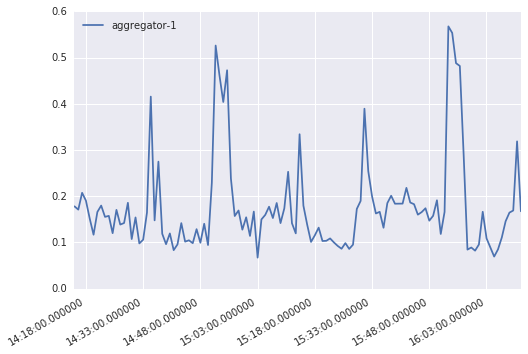

In [9]:
# N.B. A useful trick is to assign the return value of plot to _ 
# so that you don't get text printed before the plot itself.

_ = data_single_instance.plot()

## Aggregating the query

You can aggregate or summarize time series data along various dimensions.
* In the first stage, data in a time series is [aligned](https://cloud.google.com/monitoring/api/ref_v3/rest/v3/projects.timeSeries/list#Aligner) to a specified period.
* In the second stage, data from multiple time series is combined, or [reduced](https://cloud.google.com/monitoring/api/ref_v3/rest/v3/projects.timeSeries/list#Reducer), into one time series. 

Not all alignment and reduction options are applicable to all time series, depending on their metric type and value type. Alignment and reduction may change the metric type or value type of a time series.

### Aligning the query

For multiple time series, aligning the data is recommended. Aligned data is more compact to read from the Monitoring API, and lends itself better to visualizations.

The alignment period can be specified using the arguments `hours`, `minutes`, and `seconds`. In the cell below, we do the following:
* select a subset of the instances by using a prefix of the first instance name
* align the time series to 5 minute intervals using an `'ALIGN_MEAN'` method.
* plot the time series, and adjust the legend to be outside the plot. You can learn more about legend placement [here]( http://matplotlib.org/users/legend_guide.html).

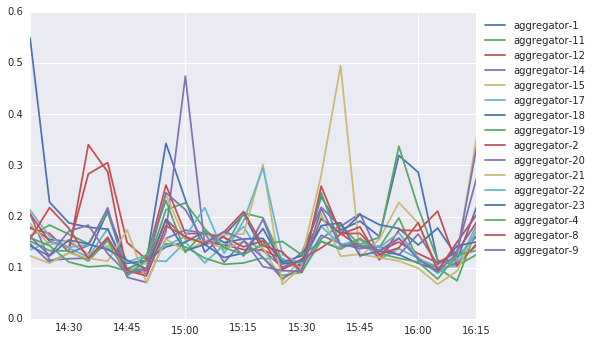

In [10]:
# Filter the query by a common instance name prefix.
common_prefix = instance_names[0].split('-')[0]
query_cpu_aligned = query_cpu.select_metrics(instance_name_prefix=common_prefix)

# Align the query to have data every 5 minutes.
query_cpu_aligned = query_cpu_aligned.align(gcm.Aligner.ALIGN_MEAN, minutes=5)
data_multiple_instances = query_cpu_aligned.as_dataframe(label='instance_name')

# Display the data as a linechart, and move the legend to the right of it.
_ = data_multiple_instances.plot().legend(loc="upper left", bbox_to_anchor=(1,1))

### Reducing the query

In order to combine the data across multiple time series, the `reduce()` method can be used. The fields to be retained after aggregation must be specified in the method.

For example, to aggregate the results by the zone, `'resource.zone'` can be specified.

In [11]:
query_cpu_reduced = query_cpu_aligned.reduce(gcm.Reducer.REDUCE_MEAN, 'resource.zone')
data_per_zone = query_cpu_reduced.as_dataframe('zone')
data_per_zone.tail(5)

,us-central1-a,us-central1-b,us-central1-c,us-central1-f
2016-09-30 15:55:00,0.121119,0.177735,0.182718,0.200774
2016-09-30 16:00:00,0.124382,0.150593,0.116170,0.172309
2016-09-30 16:05:00,0.089555,0.095923,0.094243,0.133594
2016-09-30 16:10:00,0.122888,0.118247,0.094949,0.119909
2016-09-30 16:15:00,0.199975,0.157736,0.172517,0.233819


## Displaying the time series as a heatmap

Let us look at the time series at the instance level as a heatmap. A heatmap is a compact representation of the data, and can often highlight patterns.

The diagram below shows the instances along rows, and the timestamps along columns.

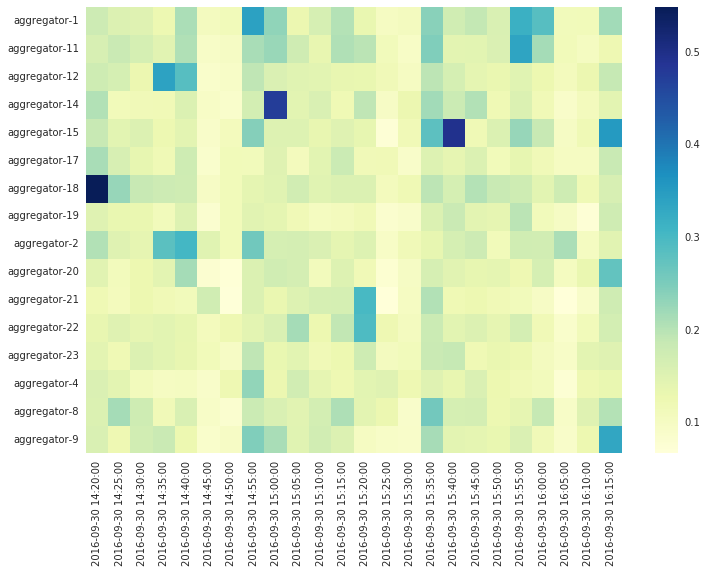

In [12]:
import matplotlib
import seaborn

# Set the size of the heatmap to have a better aspect ratio.
div_ratio = 1 if len(data_multiple_instances.columns) == 1 else 2.0
width, height = (size/div_ratio for size in data_multiple_instances.shape)
matplotlib.pyplot.figure(figsize=(width, height))

# Display the data as a heatmap. The timestamps are converted to strings
# for better readbility.
_ = seaborn.heatmap(data_multiple_instances.T,
                    xticklabels=data_multiple_instances.index.map(str),
                    cmap='YlGnBu')

## Multi-level headers

If you don't provide any labels to `as_dataframe`, it returns all the resource and metric labels present in the time series as a multi-level header.

This allows you to filter, and aggregate the data more easily.

In [13]:
data_multi_level = query_cpu_aligned.as_dataframe()
data_multi_level.tail(5)

resource_type               gce_instance                      \
project_id            monitoring-datalab                       
zone                       us-central1-a                       
instance_id         10290294917970149798 1199668422191170720   
instance_name              aggregator-20       aggregator-21   
2016-09-30 15:55:00             0.124685            0.113049   
2016-09-30 16:00:00             0.165781            0.098975   
2016-09-30 16:05:00             0.105943            0.067543   
2016-09-30 16:10:00             0.132867            0.093279   
2016-09-30 16:15:00             0.274643            0.174896   

resource_type                                                  \
project_id                                                      
zone                                            us-central1-b   
instance_id         14600525775720021528 14455506788352708841   
instance_name              aggregator-23        aggregator-17   
2016-09-30 15:55:00             0.125623             0.137173   
2016-09-30 16:00:00             0.108391             0.117783   
2016-09-30 16:05:00             0.095179             0.101609   
2016-09-30 16:10:00             0.142519             0.102198   
2016-09-30 16:15:00             0.150385             0.184001   

resource_type                                                  \
project_id                                                      
zone                                                            
instance_id         14600744951074460159 16311411540575249902   
instance_name              aggregator-14         aggregator-4   
2016-09-30 15:55:00             0.157325             0.118254   
2016-09-30 16:00:00             0.119464             0.110775   
2016-09-30 16:05:00             0.091983             0.077817   
2016-09-30 16:10:00             0.109809             0.125228   
2016-09-30 16:15:00             0.142934             0.133294   

resource_type                                                \
project_id                                                    
zone                                                          
instance_id         4985274001444675881 7935892776797307734   
instance_name              aggregator-8       aggregator-11   
2016-09-30 15:55:00            0.138708            0.337216   
2016-09-30 16:00:00            0.188256            0.216688   
2016-09-30 16:05:00            0.093591            0.114617   
2016-09-30 16:10:00            0.150019            0.103983   
2016-09-30 16:15:00            0.203160            0.125292   

resource_type                                                 \
project_id                                                     
zone                       us-central1-c                       
instance_id         12155526037933639662 8640759302133887026   
instance_name              aggregator-22       aggregator-19   
2016-09-30 15:55:00             0.168241            0.197196   
2016-09-30 16:00:00             0.118789            0.113551   
2016-09-30 16:05:00             0.088782            0.099703   
2016-09-30 16:10:00             0.115428            0.074470   
2016-09-30 16:15:00             0.169478            0.175557   

resource_type                                                  \
project_id                                                      
zone                       us-central1-f                        
instance_id         10019244077220068918 11029053306875027172   
instance_name               aggregator-1         aggregator-2   
2016-09-30 15:55:00             0.319244             0.173501   
2016-09-30 16:00:00             0.286513             0.172242   
2016-09-30 16:05:00             0.113131             0.210555   
2016-09-30 16:10:00             0.114937             0.104079   
2016-09-30 16:15:00             0.218356             0.146263   

resource_type                                               \
project_id                                                   
zone      

### Filter the dataframe

Let us filter the multi-level dataframe based on the common prefix. Applying the filter will look across all column headers.

In [14]:
print 'Finding pattern "%s" in the dataframe headers' % (common_prefix,)

Finding pattern "aggregator" in the dataframe headers


In [15]:
data_multi_level.filter(regex=common_prefix).tail(5)

resource_type               gce_instance                      \
project_id            monitoring-datalab                       
zone                       us-central1-a                       
instance_id         10290294917970149798 1199668422191170720   
instance_name              aggregator-20       aggregator-21   
2016-09-30 15:55:00             0.124685            0.113049   
2016-09-30 16:00:00             0.165781            0.098975   
2016-09-30 16:05:00             0.105943            0.067543   
2016-09-30 16:10:00             0.132867            0.093279   
2016-09-30 16:15:00             0.274643            0.174896   

resource_type                                                  \
project_id                                                      
zone                                            us-central1-b   
instance_id         14600525775720021528 14455506788352708841   
instance_name              aggregator-23        aggregator-17   
2016-09-30 15:55:00             0.125623             0.137173   
2016-09-30 16:00:00             0.108391             0.117783   
2016-09-30 16:05:00             0.095179             0.101609   
2016-09-30 16:10:00             0.142519             0.102198   
2016-09-30 16:15:00             0.150385             0.184001   

resource_type                                                  \
project_id                                                      
zone                                                            
instance_id         14600744951074460159 16311411540575249902   
instance_name              aggregator-14         aggregator-4   
2016-09-30 15:55:00             0.157325             0.118254   
2016-09-30 16:00:00             0.119464             0.110775   
2016-09-30 16:05:00             0.091983             0.077817   
2016-09-30 16:10:00             0.109809             0.125228   
2016-09-30 16:15:00             0.142934             0.133294   

resource_type                                                \
project_id                                                    
zone                                                          
instance_id         4985274001444675881 7935892776797307734   
instance_name              aggregator-8       aggregator-11   
2016-09-30 15:55:00            0.138708            0.337216   
2016-09-30 16:00:00            0.188256            0.216688   
2016-09-30 16:05:00            0.093591            0.114617   
2016-09-30 16:10:00            0.150019            0.103983   
2016-09-30 16:15:00            0.203160            0.125292   

resource_type                                                 \
project_id                                                     
zone                       us-central1-c                       
instance_id         12155526037933639662 8640759302133887026   
instance_name              aggregator-22       aggregator-19   
2016-09-30 15:55:00             0.168241            0.197196   
2016-09-30 16:00:00             0.118789            0.113551   
2016-09-30 16:05:00             0.088782            0.099703   
2016-09-30 16:10:00             0.115428            0.074470   
2016-09-30 16:15:00             0.169478            0.175557   

resource_type                                                  \
project_id                                                      
zone                       us-central1-f                        
instance_id         10019244077220068918 11029053306875027172   
instance_name               aggregator-1         aggregator-2   
2016-09-30 15:55:00             0.319244             0.173501   
2016-09-30 16:00:00             0.286513             0.172242   
2016-09-30 16:05:00             0.113131             0.210555   
2016-09-30 16:10:00             0.114937             0.104079   
2016-09-30 16:15:00             0.218356             0.146263   

resource_type                                               \
project_id                                                   
zone      

### Aggregate columns in the dataframe

Here, we aggregate the multi-level dataframe at the `zone` level. This is similar to applying reduction using `'REDUCE_MEAN'` on the field `'resource.zone'`.

In [16]:
data_multi_level.groupby(level='zone', axis=1).mean().tail(5)

zone,us-central1-a,us-central1-b,us-central1-c,us-central1-f
2016-09-30 15:55:00,0.121119,0.177735,0.182718,0.200774
2016-09-30 16:00:00,0.124382,0.150593,0.116170,0.172309
2016-09-30 16:05:00,0.089555,0.095923,0.094243,0.133594
2016-09-30 16:10:00,0.122888,0.118247,0.094949,0.119909
2016-09-30 16:15:00,0.199975,0.157736,0.172517,0.233819
